In [9]:
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import pytorch_ssim
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

In [10]:
mode = 'multiroom'
minigrid_config = {'size': [200, 200], 'epsilon': 0.5, 'oracle': True}
env_id=None
set_seed(333)

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

using seed 333


In [3]:
env.grid.height

25

In [4]:
env.goal_pos

array([15, 19])

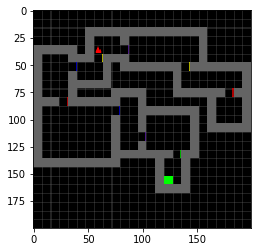

In [5]:
obs = env.reset()
plt.imshow(obs)

In [ ]:
env.step(1)
info = env.step(4)

In [ ]:
plt.imshow(info[0])

In [ ]:
for _ in range(100):
    obs = env.step(env.action_space.sample())[0]

plt.imshow(obs)

In [ ]:
plt.imshow(env.grid.render(2))

In [ ]:
plt.imshow(env.visited.T)
plt.colorbar()

In [ ]:
ex_room = env.rooms[0]

In [ ]:
ex_room.top

In [ ]:
np.array(ex_room.top) + ex_room.size - 1

In [ ]:
env.rooms[0].exitDoorPos

In [ ]:
env.get_room(env.unwrapped.agent_pos)

In [ ]:
env.step(1)
env.step(4)
plt.imshow(env.step(1)[0])

In [ ]:
env.get_room(env.unwrapped.agent_pos)

In [ ]:
env.step(1)
env.get_room(env.unwrapped.agent_pos)

In [ ]:
top_test = env.env.rooms[0].top
size_test = env.env.rooms[0].size

In [ ]:
np.array(top_test) +size_test

In [ ]:
size_test

In [ ]:
env.env.rooms[0].exitDoorPos == np.array([22, 9])

In [ ]:
top_test + size_test

In [ ]:
test = np.array([21, 10])

In [ ]:
all(test > top_test)

In [ ]:
obs = env.reset()

In [ ]:
plt.imshow(obs)

In [ ]:
env.unwrapped.agent_dir

In [ ]:
np.array([7, 3]) - np.array([4, 2])

In [ ]:
A = np.zeros(10, dtype=int)
A[:4] = 1
np.random.shuffle(A)
A

In [ ]:
A[A==1] = 1

In [ ]:
A

In [ ]:
env.unwrapped.agent_pos

In [ ]:
obs = env.step(3)[0]
plt.imshow(obs)

In [ ]:
env.place_agent(env.env.env.rooms[4].top, env.env.env.rooms[4].size)

In [ ]:
resized = resize(obs, [25, 25], anti_aliasing=True)

In [11]:
def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    
    side_size = sr_matrix.shape[0]
    
    grid = np.zeros((side_size, side_size))
    for y in range(side_size):
        for x in range(side_size):
            grid[y, x] = np.linalg.norm(sr_matrix[y, x] - starting_sr, 2)
    return grid


def visualize_dsr(sr_source, starting_pos=(1, 8), direction=-1, action=-1, normalize=True):
    if isinstance(sr_source, str):
        if 'pt' in sr_source:
            sr = torch.load(sr_source)
            sr = sr.detach().numpy()
        else:
            sr = np.load(sr_source)
    else:
        sr = sr_source

    if direction == -1:
        sr_matrix = sr.mean(axis=2)
        
    else:
        sr_matrix = sr[:, :, direction]

    if action == -1:
        sr_matrix = sr_matrix.mean(axis=2)
    else:
        sr_matrix = sr_matrix[:, :, action]
    
    side_size = sr_matrix.shape[0]
    
    if normalize:
        sr_matrix = sr_matrix.reshape(side_size ** 2, -1)
        sr_matrix = (sr_matrix - np.nanmean(sr_matrix, axis=0)) / np.nanstd(sr_matrix, axis=0)
        sr_matrix = sr_matrix.reshape(side_size, side_size, -1)
#         sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(side_size, side_size, -1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid


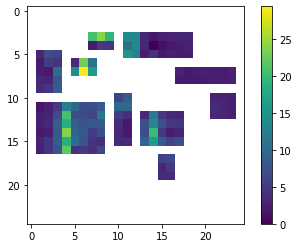

In [14]:
dsr, dsr_heatmap = visualize_dsr('../data/local/20200411/multiroom/run_0/dsr_itr_1999.pt', (4, 14), -1, -1, True)
plt.imshow(dsr_heatmap)
plt.colorbar()